# CS375 Assignment 3
### Group 8

In [8]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

## Helper Functions

In [9]:
# connect to database
# collname syntax: modelstimtype_testdatastimtype
port = 27017
conn = pm.MongoClient(port = port)
model_types = ['whitenoise', 'naturalscene']
data_stim_types = model_types

In [10]:
def delete_everything(databasename):
    steps = np.linspace(0, 1000, 21, dtype=int)
    model_types = ['whitenoise', 'naturalscene']
    data_stim_types = model_types
    for model in model_types:
        for data_stim_type in data_stim_types:
            collname = model + '_' + data_stim_type
            coll = conn[databasename][collname + '.files']
            for step in steps:
                current_exp_id = 'trainval0_' + str(step)
                coll.remove({'exp_id' : current_exp_id}, {'justOne': True})

In [11]:
def get_all_data(databasename, last_iter):
    # model = dbname
    num_ticks = last_iter / 50 + 1
    steps = np.linspace(0, last_iter, num_ticks, dtype=int)

    data = {}
    for data_stim_type in data_stim_types:
        data[data_stim_type] = {}
        
        data_key = data_stim_type + "_testcorr"
        for model in model_types:    
            collname = model + '_' + data_stim_type
            coll = conn[databasename][collname + '.files']
            curr_data = list()
            for step in steps:
                current_exp_id = 'trainval0_' + str(step)
                q_train = {'exp_id' : current_exp_id}
                curr_res = coll.find(q_train, projection=['validation_results'])
                for d in curr_res:
                    curr_data.append(d['validation_results']['valid0'][data_key])
                    
            data[data_stim_type][model] = curr_data
    return data

In [15]:
def plotCorrels(dbname, last_iter=1000):
    title1 = "Trained on natural scenes; Tested on natural scenes"
    title2 = "Trained on natural scenes; Tested on white noise"
    title3 = "Trained on white noise; Tested on natural scenes"
    title4 = "Trained on white noise; Tested on white noise"
    
    fig = plt.figure(figsize=(15, 10))
    if dbname == 'cnn':
        model_name = r'Model 0: Conv1$\rightarrow$Conv2$\rightarrow$Fc'
    elif dbname == 'ln':
        model_name = 'Model 0: LN'
    else:
        model_name = 'Model not supported'
    fig.suptitle(model_name, fontsize=16)
    
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    ax1.title.set_text(title1)
    ax2.title.set_text(title2)
    ax3.title.set_text(title3)
    ax4.title.set_text(title4)
    
    data = get_all_data(dbname, last_iter)
    
    curr_data = data['naturalscene']['naturalscene']
    ax1.plot(curr_data)
    
    curr_data = data['whitenoise']['naturalscene']
    ax2.plot(curr_data)
    
    curr_data = data['naturalscene']['whitenoise']    
    ax3.plot(curr_data)
    
    curr_data = data['whitenoise']['whitenoise']    
    ax4.plot(curr_data)

    plt.show()

## CNN Correlations

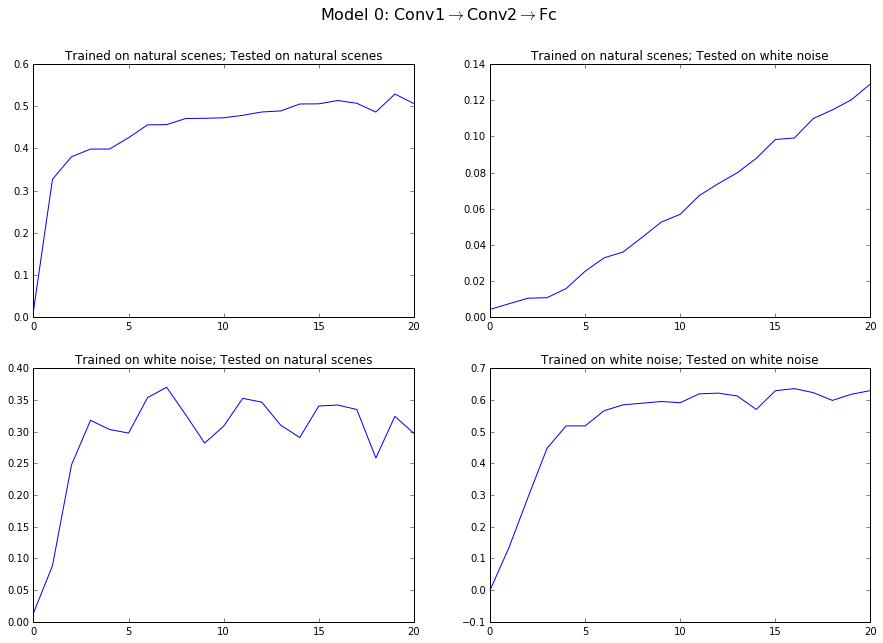

In [16]:
plotCorrels('cnn', 1000)

The correlations for data trained on X and tested on X are high as we expect. We also see that the model trained on natural scene does quite well on white noise. This shows that training on natural scenes is a good idea if we want to model the behavior of ganglion cells.

## LN Correlations

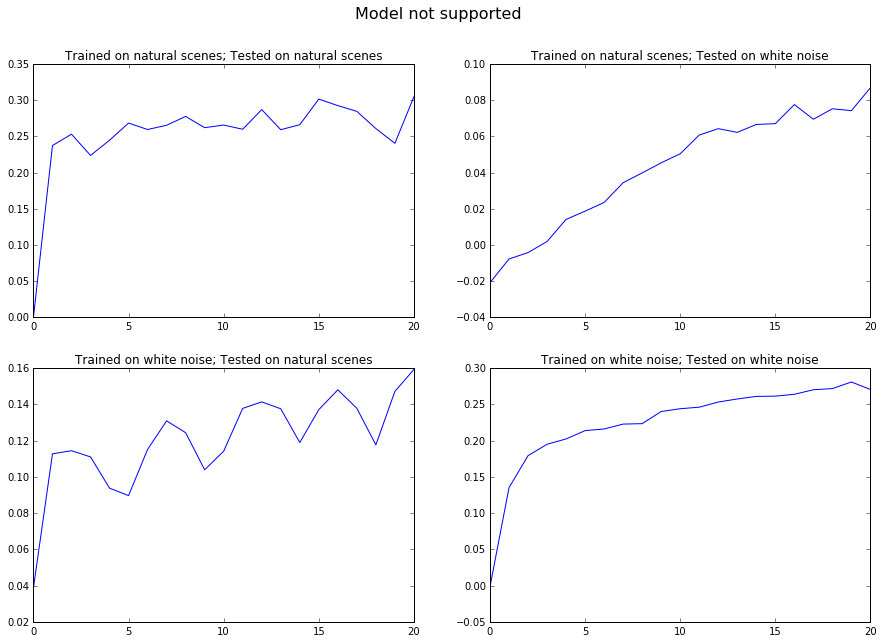

In [14]:
plotCorrels('ln_model', 1000)

We find the same trends for LN as we do for CNN. 

## Results 

The CNN trained on both natural scenes and white noise performs better than the LN model overall when testing on both sets of data. This implies that the CNN is a better model for the behavior of ganglion cells than the simpler LN model. This makes sense as the CNN is more likely to capture the transformations happening in the diverse cells in the retina.